In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import required libraries
import torch
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import time
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# set device to use GPU when available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic = True
print("PyTorch Version: ", torch.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

PyTorch Version:  2.0.1+cu118
Using GPU.


# Baseline CNN model
First, a baseline experiment was conducted to implement a basic CNN for the task at hand and observe the performance. The images are pre-processed by resizing them to 224x224 pixels, converting them to grayscale, and normalizing the pixel values. The dataset is split into train, validation, and test sets, and custom dataloaders are created for each set. 

The CNN model consists of three convolutional layers with max pooling, followed by two fully connected layers. The model is trained using the Adam optimizer and the cross-entropy loss function, for 25 epochs. During training, the model is evaluated on both the training and validation sets, and the training and validation losses and accuracies are recorded and plotted to visualize the training process. The results show that the model achieves a test accuracy of 0.8462 and an F1 score of 0.8512, with a training time of 155.41 seconds. 

In [ ]:
# Function to load and preprocess images
def preprocess_images(image_dir, image_size):
  images = []
  labels = []
  # Get a list of subdirectories (assuming each subdirectory represents a class)
  classes = os.listdir(image_dir)
  # Loop through each class
  for class_name in classes:
    class_dir = os.path.join(image_dir, class_name)
    # Get a list of image files in the class directory
    sub_classes = os.listdir(class_dir)
    for sub_class_name in sub_classes:
      sub_dir = os.path.join(class_dir, sub_class_name)
      image_files = os.listdir(sub_dir)
    # Loop through each image file
      for image_file in image_files:
        image_path = os.path.join(sub_dir, image_file)
        # print(image_path)
        # Load the image and resize it to the desired size
        image = cv2.imread(image_path)
        image = cv2.resize(image, image_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Normalize
        image = image /255.0
        # Append the image vector and label to the lists
        images.append(image)
        if sub_class_name == "healthy":
          labels.append(0)
        else:
          labels.append(1)
  # Convert the lists to numpy arrays
  images = np.array(images)
  labels = np.array(labels)
  images = np.expand_dims(images, axis=-1)
  return images, labels

# Set the path tothe image directory
image_dir = "/content/drive/MyDrive/Colab Notebooks/leaf_dataset_small/"

# Set the desired image size
image_size = (224, 224) # Adjust the size as needed

# Preprocess the images
images, labels = preprocess_images(image_dir, image_size)

# Convert the numpy arrays to PyTorch tensors
X = torch.from_numpy(images).float()
y = torch.from_numpy(labels).float()
y = y.type(torch.LongTensor)

# Split the data into train and test sets (80-20 split)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)
X_val = X_val.permute(0, 3, 1, 2)

# Define class to build custom torch datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, idx):
        batch_X = self.X[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        return batch_X, batch_y

# Create the custom datasets and dataloaders
train_dataset = CustomDataset(X_train, y_train, batch_size=32)
test_dataset = CustomDataset(X_test, y_test, batch_size=32)
val_dataset = CustomDataset(X_val, y_val, batch_size=32)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=None, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=None, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=None, shuffle=False)

In [ ]:
# Define the CNN model
class LeafClassifier(nn.Module):
    def __init__(self):
        super(LeafClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        # x = x.view(-1, 128 * 56 * 56)
        x = x.reshape(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model and move it to the device
model = LeafClassifier().to(DEVICE)

# Define the loss function, optimizer and number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 25

Epoch 1/25: Train Loss: 22.2555, Train Acc: 0.5785, Val Loss: 21.1290, Val Acc: 0.6101
Epoch 2/25: Train Loss: 20.2578, Train Acc: 0.6283, Val Loss: 20.1276, Val Acc: 0.6280
Epoch 3/25: Train Loss: 18.2253, Train Acc: 0.7013, Val Loss: 17.8918, Val Acc: 0.6994
Epoch 4/25: Train Loss: 16.7998, Train Acc: 0.7333, Val Loss: 17.2265, Val Acc: 0.7083
Epoch 5/25: Train Loss: 14.9962, Train Acc: 0.7753, Val Loss: 16.1026, Val Acc: 0.7500
Epoch 6/25: Train Loss: 13.1583, Train Acc: 0.8155, Val Loss: 15.7819, Val Acc: 0.7723
Epoch 7/25: Train Loss: 9.8039, Train Acc: 0.8650, Val Loss: 15.1839, Val Acc: 0.7768
Epoch 8/25: Train Loss: 7.9130, Train Acc: 0.8977, Val Loss: 15.9621, Val Acc: 0.7768
Epoch 9/25: Train Loss: 6.2218, Train Acc: 0.9282, Val Loss: 16.2193, Val Acc: 0.7976
Epoch 10/25: Train Loss: 4.7650, Train Acc: 0.9423, Val Loss: 18.4963, Val Acc: 0.7812
Epoch 11/25: Train Loss: 3.4992, Train Acc: 0.9621, Val Loss: 20.8125, Val Acc: 0.8095
Epoch 12/25: Train Loss: 2.0137, Train Acc: 0.

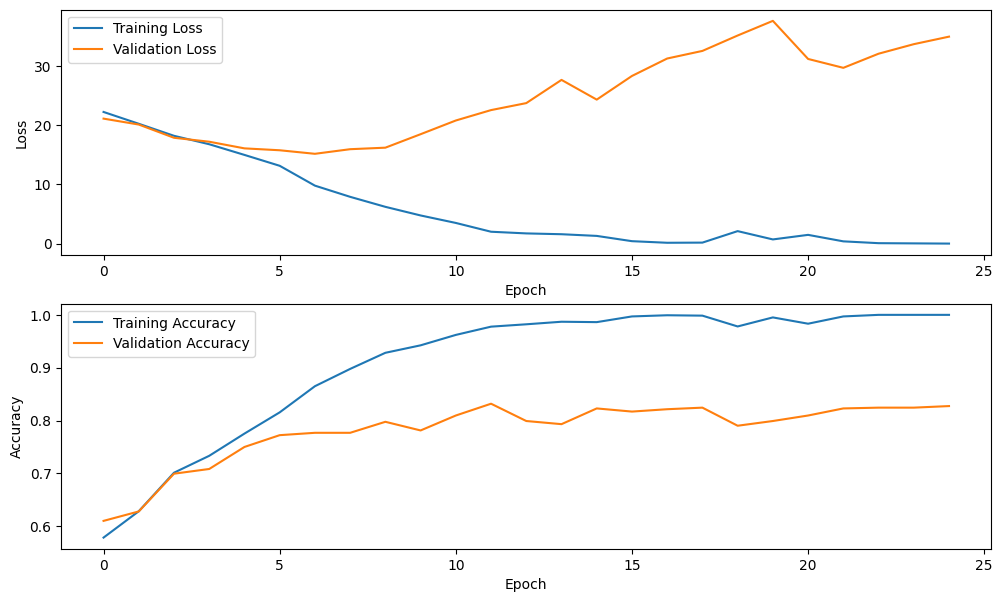

In [ ]:
# Train the model
train_losses = []
train_accs = []
val_losses = []
val_accs = []

starttime = time.time()

for epoch in range(num_epochs):
    # Train the model for one epoch
    model.train()
    running_loss = 0.0
    running_corrects = 0
    train_predictions = []
    train_labels = []
    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        # running_corrects += torch.sum(preds == labels.data)
        train_predictions += preds.tolist()
        train_labels += labels.tolist()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = accuracy_score(train_labels, train_predictions)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Test the model for one epoch
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            # running_corrects += torch.sum(preds == labels.data)
            val_predictions += preds.tolist()
            val_labels += labels.tolist()
    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = accuracy_score(val_labels, val_predictions)
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

# Print the training time
runtime = time.time() - starttime
print(f'Time taken to train: {runtime:.2f} seconds')

# Plot the training and testing losses and accuracies
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Test the model on test data

# Put the model in evaluation mode
model.eval()

# Create a dataloader for the test set
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define some variables to keep track of the test statistics
test_running_loss = 0.0
test_running_corrects = 0
test_predictions = []
test_labels = []

# Iterate over the test set
for inputs, labels in test_dataloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Compute loss and accuracy
    loss = criterion(outputs, labels)
    test_running_loss += loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(preds == labels.data)

    # Collect predictions and labels for computing metrics later
    test_predictions += preds.tolist()
    test_labels += labels.tolist()

# Compute test loss and accuracy
test_loss = test_running_loss / len(test_dataset)
test_accuracy = accuracy_score(test_labels,test_predictions)

# Compute F1 score and classification report
test_f1_score = f1_score(test_labels,test_predictions)
test_classification_report = classification_report(test_labels, test_predictions)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}')
print(f'Test Classification Report:\n{test_classification_report}')

Test Loss: 29.2646, Test Accuracy: 0.8462, Test F1 Score: 0.8512
Test Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       399
           1       0.86      0.85      0.85       433

    accuracy                           0.85       832
   macro avg       0.85      0.85      0.85       832
weighted avg       0.85      0.85      0.85       832



---
---
---

# Experiment 1: Changing the CNN model architecture 

For the first experiment, some changes were made to the CNN model architecture to try and improve the accuracy and overall model performance. The following changes were made: <br>

- Increased the number of filters in the first convolutional layer to 64 and added another convolutional layer with 128 filters. Increasing the number of filters in each convolutional layer can help the model to learn more complex and abstract features from the images. 

- Added a third convolutional layer with 256 filters. Adding more convolutional layers to the model can help it to learn more complex features from the images. However, adding too many layers can also lead to overfitting. 

- Increased the size of the fully connected layers to 1024 and 256, respectively. Increasing the size of the fully connected layers can help the model to learn more complex decision boundaries. However, adding too many parameters can also lead to overfitting 

- Added dropout layers to prevent overfitting by randomly dropping out some of the neurons during training. This can help to improve the generalization performance of the model. 

In [ ]:
# Define the CNN model
class LeafClassifier(nn.Module):
    def __init__(self):
        super(LeafClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.reshape(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Create the model and move it to the device
model = LeafClassifier().to(DEVICE)

# Define the loss function, optimizer and number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 25

Epoch 1/25: Train Loss: 23.4612, Train Acc: 0.4996, Val Loss: 22.1790, Val Acc: 0.5208
Epoch 2/25: Train Loss: 22.1872, Train Acc: 0.4989, Val Loss: 22.1769, Val Acc: 0.5208
Epoch 3/25: Train Loss: 22.1881, Train Acc: 0.4944, Val Loss: 22.1752, Val Acc: 0.5208
Epoch 4/25: Train Loss: 22.1890, Train Acc: 0.4918, Val Loss: 22.1682, Val Acc: 0.5208
Epoch 5/25: Train Loss: 22.1879, Train Acc: 0.4862, Val Loss: 22.1728, Val Acc: 0.5208
Epoch 6/25: Train Loss: 22.1853, Train Acc: 0.5030, Val Loss: 22.1707, Val Acc: 0.5208
Epoch 7/25: Train Loss: 22.1817, Train Acc: 0.4948, Val Loss: 22.1856, Val Acc: 0.4792
Epoch 8/25: Train Loss: 22.1845, Train Acc: 0.4989, Val Loss: 22.1786, Val Acc: 0.5208
Epoch 9/25: Train Loss: 22.1899, Train Acc: 0.4907, Val Loss: 22.1800, Val Acc: 0.5208
Epoch 10/25: Train Loss: 22.1909, Train Acc: 0.4900, Val Loss: 22.1656, Val Acc: 0.5208
Epoch 11/25: Train Loss: 22.1851, Train Acc: 0.4970, Val Loss: 22.1749, Val Acc: 0.5208
Epoch 12/25: Train Loss: 22.1773, Train A

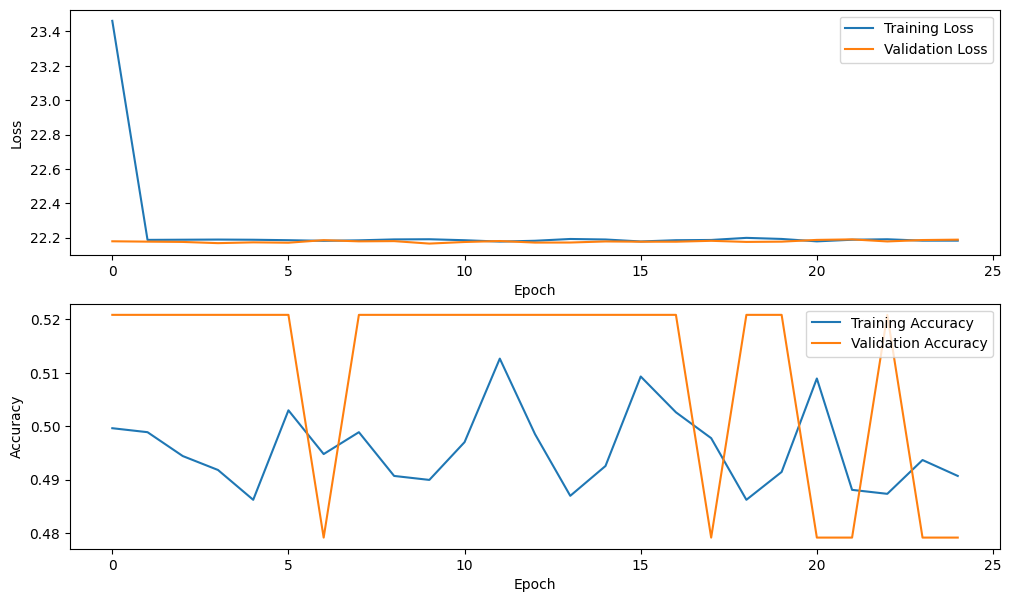

In [ ]:
# Train the model
train_losses = []
train_accs = []
val_losses = []
val_accs = []

starttime = time.time()

for epoch in range(num_epochs):
    # Train the model for one epoch
    model.train()
    running_loss = 0.0
    running_corrects = 0
    train_predictions = []
    train_labels = []
    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        # running_corrects += torch.sum(preds == labels.data)
        train_predictions += preds.tolist()
        train_labels += labels.tolist()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = accuracy_score(train_labels, train_predictions)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Test the model for one epoch
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            # running_corrects += torch.sum(preds == labels.data)
            val_predictions += preds.tolist()
            val_labels += labels.tolist()
    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = accuracy_score(val_labels, val_predictions)
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

# Print the training time
runtime = time.time() - starttime
print(f'Time taken to train: {runtime:.2f} seconds')

# Plot the training and testing losses and accuracies
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

However, upon making these changes together, the model performs erratically as seen by the learning curves of the training process. 

In [ ]:
# Test the model on test data

# Put the model in evaluation mode
model.eval()

# Create a dataloader for the test set
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define some variables to keep track of the test statistics
test_running_loss = 0.0
test_running_corrects = 0
test_predictions = []
test_labels = []

# Iterate over the test set
for inputs, labels in test_dataloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Compute loss and accuracy
    loss = criterion(outputs, labels)
    test_running_loss += loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(preds == labels.data)

    # Collect predictions and labels for computing metrics later
    test_predictions += preds.tolist()
    test_labels += labels.tolist()

# Compute test loss and accuracy
test_loss = test_running_loss / len(test_dataset)
test_accuracy = accuracy_score(test_labels,test_predictions)

# Compute F1 score and classification report
test_f1_score = f1_score(test_labels,test_predictions)
test_classification_report = classification_report(test_labels, test_predictions)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}')
print(f'Test Classification Report:\n{test_classification_report}')

Test Loss: 22.1740, Test Accuracy: 0.5204, Test F1 Score: 0.6846
Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       399
           1       0.52      1.00      0.68       433

    accuracy                           0.52       832
   macro avg       0.26      0.50      0.34       832
weighted avg       0.27      0.52      0.36       832



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---
The training and validation losses are flat and together which implies a good model fit. However, the accuracy curves are fluctuating indicating a problem with the model. Upon further investigation, the classification report reveals that class 0 (healthy leaves) has an f1 score of 0. This model is not classifying healthy leaves at all and only classifies the diseased leaves correctly sometimes. Thus, this experiment failed at improving model performance and the original CNN will be used for further experiments. 

---
---
---

# Experiment 2: Using individual RGB colour channels instead of grayscale

The images had to be converted to grayscale instead of using the 3 RGB colour channels because they had to fit the GPU RAM in batches. Without this conversion to using 1 channel instead of all 3, the training kept crashing and using a CPU instead of a GPU was not feasible as per the time taken to train. Thus, for this experiment, each colour channel of the images was isolated in the preprocessing step and used instead of the grayscale images. The model performed the best when using the isolated red channel with Test Loss of 37.2305, Test Accuracy of 0.8630, and Test F1 Score: 0.8665. This is a good improvement over the original accuracy and loss of 0.8462 and 0.8512 respectively. (Wk3pg40) 

## Red

In [ ]:
# Function to load and preprocess images
def preprocess_images(image_dir, image_size):
  images = []
  labels = []
  # Get a list of subdirectories (assuming each subdirectory represents a class)
  classes = os.listdir(image_dir)
  # Loop through each class
  for class_name in classes:
    class_dir = os.path.join(image_dir, class_name)
    # Get a list of image files in the class directory
    sub_classes = os.listdir(class_dir)
    for sub_class_name in sub_classes:
      sub_dir = os.path.join(class_dir, sub_class_name)
      image_files = os.listdir(sub_dir)
    # Loop through each image file
      for image_file in image_files:
        image_path = os.path.join(sub_dir, image_file)
        # print(image_path)
        # Load the image and resize it to the desired size
        image = cv2.imread(image_path)
        image = cv2.resize(image, image_size)
        image = image[:, :, 2]
        # Normalize
        image = image /255.0
        # Append the image vector and label to the lists
        images.append(image)
        if sub_class_name == "healthy":
          labels.append(0)
        else:
          labels.append(1)
  # Convert the lists to numpy arrays
  images = np.array(images)
  labels = np.array(labels)
  images = np.expand_dims(images, axis=-1)
  return images, labels

# Set the path tothe image directory
image_dir = "/content/drive/MyDrive/Colab Notebooks/leaf_dataset_small/"

# Set the desired image size
image_size = (224, 224) # Adjust the size as needed

# Preprocess the images
images, labels = preprocess_images(image_dir, image_size)

# Convert the numpy arrays to PyTorch tensors
X = torch.from_numpy(images).float()
y = torch.from_numpy(labels).float()
y = y.type(torch.LongTensor)

# Split the data into train and test sets (80-20 split)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)
X_val = X_val.permute(0, 3, 1, 2)

# Define class to build custom torch datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, idx):
        batch_X = self.X[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        return batch_X, batch_y

# Create the custom datasets and dataloaders
train_dataset = CustomDataset(X_train, y_train, batch_size=32)
test_dataset = CustomDataset(X_test, y_test, batch_size=32)
val_dataset = CustomDataset(X_val, y_val, batch_size=32)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=None, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=None, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=None, shuffle=False)

In [ ]:
# Define the CNN model
class LeafClassifier(nn.Module):
    def __init__(self):
        super(LeafClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        # x = x.view(-1, 128 * 56 * 56)
        x = x.reshape(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model and move it to the device
model = LeafClassifier().to(DEVICE)

# Define the loss function, optimizer and number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 25

Epoch 1/25: Train Loss: 22.5137, Train Acc: 0.5826, Val Loss: 20.2776, Val Acc: 0.6756
Epoch 2/25: Train Loss: 19.3908, Train Acc: 0.6778, Val Loss: 18.7819, Val Acc: 0.6592
Epoch 3/25: Train Loss: 17.4565, Train Acc: 0.7106, Val Loss: 19.5770, Val Acc: 0.6786
Epoch 4/25: Train Loss: 15.1421, Train Acc: 0.7645, Val Loss: 14.9014, Val Acc: 0.7842
Epoch 5/25: Train Loss: 12.7425, Train Acc: 0.8110, Val Loss: 13.8467, Val Acc: 0.8095
Epoch 6/25: Train Loss: 11.2990, Train Acc: 0.8359, Val Loss: 14.5322, Val Acc: 0.7812
Epoch 7/25: Train Loss: 9.4582, Train Acc: 0.8731, Val Loss: 12.9956, Val Acc: 0.8244
Epoch 8/25: Train Loss: 7.6372, Train Acc: 0.9051, Val Loss: 16.0104, Val Acc: 0.8080
Epoch 9/25: Train Loss: 5.1426, Train Acc: 0.9386, Val Loss: 17.8155, Val Acc: 0.8289
Epoch 10/25: Train Loss: 3.5876, Train Acc: 0.9613, Val Loss: 18.9042, Val Acc: 0.8274
Epoch 11/25: Train Loss: 2.3392, Train Acc: 0.9754, Val Loss: 19.4624, Val Acc: 0.8259
Epoch 12/25: Train Loss: 1.4907, Train Acc: 0.

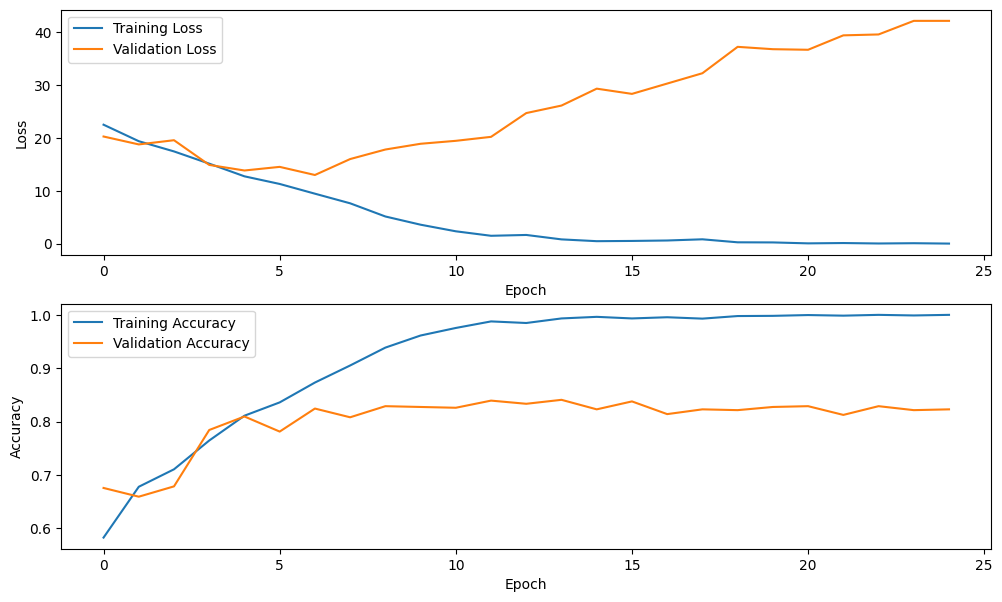

In [ ]:
# Train the model
train_losses = []
train_accs = []
val_losses = []
val_accs = []

starttime = time.time()

for epoch in range(num_epochs):
    # Train the model for one epoch
    model.train()
    running_loss = 0.0
    running_corrects = 0
    train_predictions = []
    train_labels = []
    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        # running_corrects += torch.sum(preds == labels.data)
        train_predictions += preds.tolist()
        train_labels += labels.tolist()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = accuracy_score(train_labels, train_predictions)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Test the model for one epoch
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            # running_corrects += torch.sum(preds == labels.data)
            val_predictions += preds.tolist()
            val_labels += labels.tolist()
    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = accuracy_score(val_labels, val_predictions)
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

# Print the training time
runtime = time.time() - starttime
print(f'Time taken to train: {runtime:.2f} seconds')

# Plot the training and testing losses and accuracies
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Test the model on test data

# Put the model in evaluation mode
model.eval()

# Create a dataloader for the test set
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define some variables to keep track of the test statistics
test_running_loss = 0.0
test_running_corrects = 0
test_predictions = []
test_labels = []

# Iterate over the test set
for inputs, labels in test_dataloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Compute loss and accuracy
    loss = criterion(outputs, labels)
    test_running_loss += loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(preds == labels.data)

    # Collect predictions and labels for computing metrics later
    test_predictions += preds.tolist()
    test_labels += labels.tolist()

# Compute test loss and accuracy
test_loss = test_running_loss / len(test_dataset)
test_accuracy = accuracy_score(test_labels,test_predictions)

# Compute F1 score and classification report
test_f1_score = f1_score(test_labels,test_predictions)
test_classification_report = classification_report(test_labels, test_predictions)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}')
print(f'Test Classification Report:\n{test_classification_report}')

Test Loss: 37.2305, Test Accuracy: 0.8630, Test F1 Score: 0.8665
Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       399
           1       0.88      0.85      0.87       433

    accuracy                           0.86       832
   macro avg       0.86      0.86      0.86       832
weighted avg       0.86      0.86      0.86       832



___

## Green

In [ ]:
# Function to load and preprocess images
def preprocess_images(image_dir, image_size):
  images = []
  labels = []
  # Get a list of subdirectories (assuming each subdirectory represents a class)
  classes = os.listdir(image_dir)
  # Loop through each class
  for class_name in classes:
    class_dir = os.path.join(image_dir, class_name)
    # Get a list of image files in the class directory
    sub_classes = os.listdir(class_dir)
    for sub_class_name in sub_classes:
      sub_dir = os.path.join(class_dir, sub_class_name)
      image_files = os.listdir(sub_dir)
    # Loop through each image file
      for image_file in image_files:
        image_path = os.path.join(sub_dir, image_file)
        # print(image_path)
        # Load the image and resize it to the desired size
        image = cv2.imread(image_path)
        image = cv2.resize(image, image_size)
        image = image[:, :, 1]
        # Normalize
        image = image /255.0
        # Append the image vector and label to the lists
        images.append(image)
        if sub_class_name == "healthy":
          labels.append(0)
        else:
          labels.append(1)
  # Convert the lists to numpy arrays
  images = np.array(images)
  labels = np.array(labels)
  images = np.expand_dims(images, axis=-1)
  return images, labels

# Set the path tothe image directory
image_dir = "/content/drive/MyDrive/Colab Notebooks/leaf_dataset_small/"

# Set the desired image size
image_size = (224, 224) # Adjust the size as needed

# Preprocess the images
images, labels = preprocess_images(image_dir, image_size)

# Convert the numpy arrays to PyTorch tensors
X = torch.from_numpy(images).float()
y = torch.from_numpy(labels).float()
y = y.type(torch.LongTensor)

# Split the data into train and test sets (80-20 split)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)
X_val = X_val.permute(0, 3, 1, 2)

# Define class to build custom torch datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, idx):
        batch_X = self.X[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        return batch_X, batch_y

# Create the custom datasets and dataloaders
train_dataset = CustomDataset(X_train, y_train, batch_size=32)
test_dataset = CustomDataset(X_test, y_test, batch_size=32)
val_dataset = CustomDataset(X_val, y_val, batch_size=32)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=None, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=None, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=None, shuffle=False)

In [ ]:
# Define the CNN model
class LeafClassifier(nn.Module):
    def __init__(self):
        super(LeafClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        # x = x.view(-1, 128 * 56 * 56)
        x = x.reshape(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model and move it to the device
model = LeafClassifier().to(DEVICE)

# Define the loss function, optimizer and number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 25

Epoch 1/25: Train Loss: 22.4727, Train Acc: 0.5733, Val Loss: 21.2297, Val Acc: 0.5729
Epoch 2/25: Train Loss: 20.0325, Train Acc: 0.6354, Val Loss: 18.9630, Val Acc: 0.6652
Epoch 3/25: Train Loss: 17.6127, Train Acc: 0.7042, Val Loss: 17.5251, Val Acc: 0.7083
Epoch 4/25: Train Loss: 15.4197, Train Acc: 0.7656, Val Loss: 16.0453, Val Acc: 0.7574
Epoch 5/25: Train Loss: 12.3793, Train Acc: 0.8237, Val Loss: 17.3943, Val Acc: 0.7530
Epoch 6/25: Train Loss: 10.5631, Train Acc: 0.8612, Val Loss: 16.4532, Val Acc: 0.7723
Epoch 7/25: Train Loss: 8.6116, Train Acc: 0.8951, Val Loss: 17.9320, Val Acc: 0.7872
Epoch 8/25: Train Loss: 5.7937, Train Acc: 0.9349, Val Loss: 25.7904, Val Acc: 0.7396
Epoch 9/25: Train Loss: 5.2530, Train Acc: 0.9356, Val Loss: 21.6995, Val Acc: 0.7738
Epoch 10/25: Train Loss: 3.3506, Train Acc: 0.9654, Val Loss: 22.4785, Val Acc: 0.8125
Epoch 11/25: Train Loss: 1.7352, Train Acc: 0.9810, Val Loss: 28.0889, Val Acc: 0.8006
Epoch 12/25: Train Loss: 0.8655, Train Acc: 0.

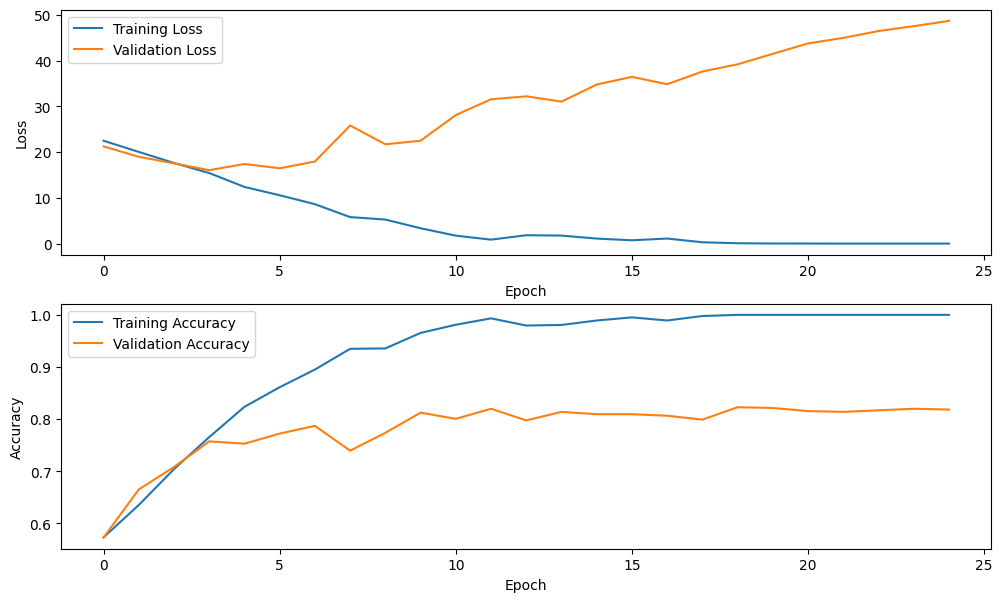

In [ ]:
# Train the model
train_losses = []
train_accs = []
val_losses = []
val_accs = []

starttime = time.time()

for epoch in range(num_epochs):
    # Train the model for one epoch
    model.train()
    running_loss = 0.0
    running_corrects = 0
    train_predictions = []
    train_labels = []
    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        # running_corrects += torch.sum(preds == labels.data)
        train_predictions += preds.tolist()
        train_labels += labels.tolist()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = accuracy_score(train_labels, train_predictions)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Test the model for one epoch
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            # running_corrects += torch.sum(preds == labels.data)
            val_predictions += preds.tolist()
            val_labels += labels.tolist()
    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = accuracy_score(val_labels, val_predictions)
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

# Print the training time
runtime = time.time() - starttime
print(f'Time taken to train: {runtime:.2f} seconds')

# Plot the training and testing losses and accuracies
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Test the model on test data

# Put the model in evaluation mode
model.eval()

# Create a dataloader for the test set
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define some variables to keep track of the test statistics
test_running_loss = 0.0
test_running_corrects = 0
test_predictions = []
test_labels = []

# Iterate over the test set
for inputs, labels in test_dataloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Compute loss and accuracy
    loss = criterion(outputs, labels)
    test_running_loss += loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(preds == labels.data)

    # Collect predictions and labels for computing metrics later
    test_predictions += preds.tolist()
    test_labels += labels.tolist()

# Compute test loss and accuracy
test_loss = test_running_loss / len(test_dataset)
test_accuracy = accuracy_score(test_labels,test_predictions)

# Compute F1 score and classification report
test_f1_score = f1_score(test_labels,test_predictions)
test_classification_report = classification_report(test_labels, test_predictions)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}')
print(f'Test Classification Report:\n{test_classification_report}')

Test Loss: 35.9337, Test Accuracy: 0.8570, Test F1 Score: 0.8615
Test Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       399
           1       0.87      0.85      0.86       433

    accuracy                           0.86       832
   macro avg       0.86      0.86      0.86       832
weighted avg       0.86      0.86      0.86       832



___

## Blue

In [ ]:
# Function to load and preprocess images
def preprocess_images(image_dir, image_size):
  images = []
  labels = []
  # Get a list of subdirectories (assuming each subdirectory represents a class)
  classes = os.listdir(image_dir)
  # Loop through each class
  for class_name in classes:
    class_dir = os.path.join(image_dir, class_name)
    # Get a list of image files in the class directory
    sub_classes = os.listdir(class_dir)
    for sub_class_name in sub_classes:
      sub_dir = os.path.join(class_dir, sub_class_name)
      image_files = os.listdir(sub_dir)
    # Loop through each image file
      for image_file in image_files:
        image_path = os.path.join(sub_dir, image_file)
        # print(image_path)
        # Load the image and resize it to the desired size
        image = cv2.imread(image_path)
        image = cv2.resize(image, image_size)
        image = image[:, :, 0]
        # Normalize
        image = image /255.0
        # Append the image vector and label to the lists
        images.append(image)
        if sub_class_name == "healthy":
          labels.append(0)
        else:
          labels.append(1)
  # Convert the lists to numpy arrays
  images = np.array(images)
  labels = np.array(labels)
  images = np.expand_dims(images, axis=-1)
  return images, labels

# Set the path tothe image directory
image_dir = "/content/drive/MyDrive/Colab Notebooks/leaf_dataset_small/"

# Set the desired image size
image_size = (224, 224) # Adjust the size as needed

# Preprocess the images
images, labels = preprocess_images(image_dir, image_size)

# Convert the numpy arrays to PyTorch tensors
X = torch.from_numpy(images).float()
y = torch.from_numpy(labels).float()
y = y.type(torch.LongTensor)

# Split the data into train and test sets (80-20 split)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)
X_val = X_val.permute(0, 3, 1, 2)

# Define class to build custom torch datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, idx):
        batch_X = self.X[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        return batch_X, batch_y

# Create the custom datasets and dataloaders
train_dataset = CustomDataset(X_train, y_train, batch_size=32)
test_dataset = CustomDataset(X_test, y_test, batch_size=32)
val_dataset = CustomDataset(X_val, y_val, batch_size=32)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=None, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=None, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=None, shuffle=False)

In [ ]:
# Define the CNN model
class LeafClassifier(nn.Module):
    def __init__(self):
        super(LeafClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        # x = x.view(-1, 128 * 56 * 56)
        x = x.reshape(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model and move it to the device
model = LeafClassifier().to(DEVICE)

# Define the loss function, optimizer and number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 25

Epoch 1/25: Train Loss: 22.9536, Train Acc: 0.5357, Val Loss: 22.4411, Val Acc: 0.5476
Epoch 2/25: Train Loss: 20.6601, Train Acc: 0.6339, Val Loss: 19.4163, Val Acc: 0.6637
Epoch 3/25: Train Loss: 18.1922, Train Acc: 0.7065, Val Loss: 18.2861, Val Acc: 0.7128
Epoch 4/25: Train Loss: 16.1208, Train Acc: 0.7571, Val Loss: 19.8556, Val Acc: 0.7158
Epoch 5/25: Train Loss: 13.8834, Train Acc: 0.8065, Val Loss: 15.3167, Val Acc: 0.7708
Epoch 6/25: Train Loss: 12.0803, Train Acc: 0.8311, Val Loss: 16.1707, Val Acc: 0.7783
Epoch 7/25: Train Loss: 9.2253, Train Acc: 0.8728, Val Loss: 15.1981, Val Acc: 0.8021
Epoch 8/25: Train Loss: 6.7892, Train Acc: 0.9126, Val Loss: 17.0369, Val Acc: 0.7991
Epoch 9/25: Train Loss: 4.8955, Train Acc: 0.9431, Val Loss: 19.4453, Val Acc: 0.8155
Epoch 10/25: Train Loss: 3.4213, Train Acc: 0.9621, Val Loss: 24.4425, Val Acc: 0.7872
Epoch 11/25: Train Loss: 2.1563, Train Acc: 0.9769, Val Loss: 25.2678, Val Acc: 0.8051
Epoch 12/25: Train Loss: 1.4086, Train Acc: 0.

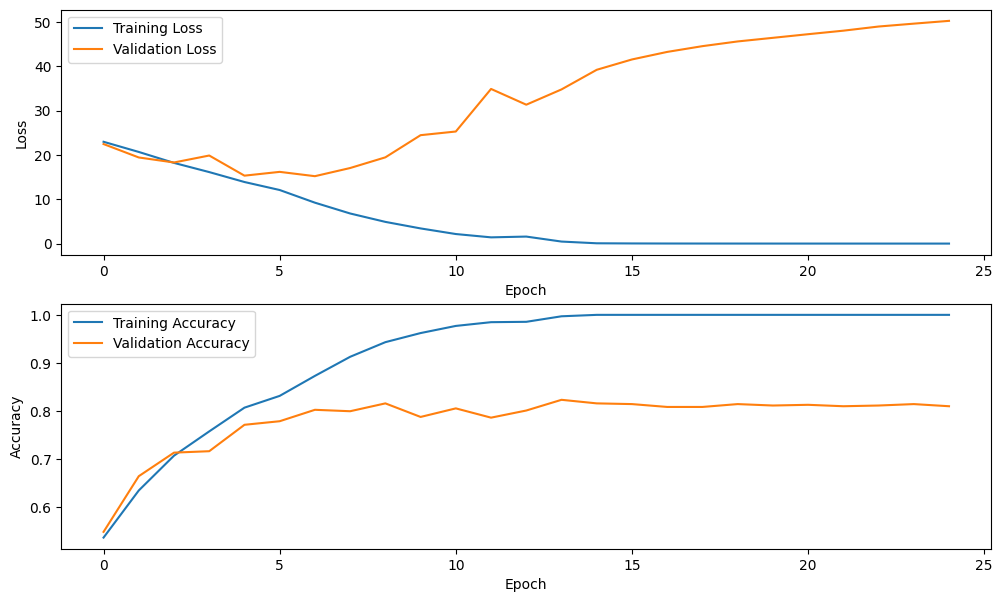

In [ ]:
# Train the model
train_losses = []
train_accs = []
val_losses = []
val_accs = []

starttime = time.time()

for epoch in range(num_epochs):
    # Train the model for one epoch
    model.train()
    running_loss = 0.0
    running_corrects = 0
    train_predictions = []
    train_labels = []
    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        # running_corrects += torch.sum(preds == labels.data)
        train_predictions += preds.tolist()
        train_labels += labels.tolist()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = accuracy_score(train_labels, train_predictions)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Test the model for one epoch
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            # running_corrects += torch.sum(preds == labels.data)
            val_predictions += preds.tolist()
            val_labels += labels.tolist()
    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = accuracy_score(val_labels, val_predictions)
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

# Print the training time
runtime = time.time() - starttime
print(f'Time taken to train: {runtime:.2f} seconds')

# Plot the training and testing losses and accuracies
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Test the model on test data

# Put the model in evaluation mode
model.eval()

# Create a dataloader for the test set
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define some variables to keep track of the test statistics
test_running_loss = 0.0
test_running_corrects = 0
test_predictions = []
test_labels = []

# Iterate over the test set
for inputs, labels in test_dataloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Compute loss and accuracy
    loss = criterion(outputs, labels)
    test_running_loss += loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(preds == labels.data)

    # Collect predictions and labels for computing metrics later
    test_predictions += preds.tolist()
    test_labels += labels.tolist()

# Compute test loss and accuracy
test_loss = test_running_loss / len(test_dataset)
test_accuracy = accuracy_score(test_labels,test_predictions)

# Compute F1 score and classification report
test_f1_score = f1_score(test_labels,test_predictions)
test_classification_report = classification_report(test_labels, test_predictions)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}')
print(f'Test Classification Report:\n{test_classification_report}')

Test Loss: 49.3854, Test Accuracy: 0.8329, Test F1 Score: 0.8386
Test Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       399
           1       0.84      0.83      0.84       433

    accuracy                           0.83       832
   macro avg       0.83      0.83      0.83       832
weighted avg       0.83      0.83      0.83       832



---
---
---

# Experiment 3: Hyperparameter tuning
Experiment 3 aimed to optimize the performance of the CNN through hyperparameter tuning. The optimization process involved changing the optimizer from Adam to Stochastic Gradient Descent (SGD) and experimenting with different learning rates of 0.0001 and 0.001. Furthermore, the number of epochs was increased from 25 to 100 to allow the model to train for a longer duration after observing a peak towards the end of the training curves. However, the results revealed that the Adam optimizer still outperformed SGD in terms of accuracy and F1 score. 

In [ ]:
# Function to load and preprocess images
def preprocess_images(image_dir, image_size):
  images = []
  labels = []
  # Get a list of subdirectories (assuming each subdirectory represents a class)
  classes = os.listdir(image_dir)
  # Loop through each class
  for class_name in classes:
    class_dir = os.path.join(image_dir, class_name)
    # Get a list of image files in the class directory
    sub_classes = os.listdir(class_dir)
    for sub_class_name in sub_classes:
      sub_dir = os.path.join(class_dir, sub_class_name)
      image_files = os.listdir(sub_dir)
    # Loop through each image file
      for image_file in image_files:
        image_path = os.path.join(sub_dir, image_file)
        # print(image_path)
        # Load the image and resize it to the desired size
        image = cv2.imread(image_path)
        image = cv2.resize(image, image_size)
        image = image[:, :, 2]
        # Normalize
        image = image /255.0
        # Append the image vector and label to the lists
        images.append(image)
        if sub_class_name == "healthy":
          labels.append(0)
        else:
          labels.append(1)
  # Convert the lists to numpy arrays
  images = np.array(images)
  labels = np.array(labels)
  images = np.expand_dims(images, axis=-1)
  return images, labels

# Set the path tothe image directory
image_dir = "/content/drive/MyDrive/Colab Notebooks/leaf_dataset_small/"

# Set the desired image size
image_size = (224, 224) # Adjust the size as needed

# Preprocess the images
images, labels = preprocess_images(image_dir, image_size)

# Convert the numpy arrays to PyTorch tensors
X = torch.from_numpy(images).float()
y = torch.from_numpy(labels).float()
y = y.type(torch.LongTensor)

# Split the data into train and test sets (80-20 split)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)
X_val = X_val.permute(0, 3, 1, 2)

# Define class to build custom torch datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, idx):
        batch_X = self.X[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        return batch_X, batch_y

# Create the custom datasets and dataloaders
train_dataset = CustomDataset(X_train, y_train, batch_size=32)
test_dataset = CustomDataset(X_test, y_test, batch_size=32)
val_dataset = CustomDataset(X_val, y_val, batch_size=32)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=None, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=None, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=None, shuffle=False)

In [ ]:
# Define the CNN model
class LeafClassifier(nn.Module):
    def __init__(self):
        super(LeafClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        # x = x.view(-1, 128 * 56 * 56)
        x = x.reshape(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model and move it to the device
model = LeafClassifier().to(DEVICE)

# Define the loss function, optimizer and number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)
num_epochs = 25

Epoch 1/25: Train Loss: 22.1782, Train Acc: 0.4985, Val Loss: 22.1869, Val Acc: 0.4792
Epoch 2/25: Train Loss: 22.1611, Train Acc: 0.4985, Val Loss: 22.1673, Val Acc: 0.4792
Epoch 3/25: Train Loss: 22.1478, Train Acc: 0.5134, Val Loss: 22.1558, Val Acc: 0.4792
Epoch 4/25: Train Loss: 22.1358, Train Acc: 0.5190, Val Loss: 22.1435, Val Acc: 0.4970
Epoch 5/25: Train Loss: 22.1233, Train Acc: 0.5428, Val Loss: 22.1316, Val Acc: 0.5149
Epoch 6/25: Train Loss: 22.1091, Train Acc: 0.5614, Val Loss: 22.1187, Val Acc: 0.5417
Epoch 7/25: Train Loss: 22.0956, Train Acc: 0.5770, Val Loss: 22.1053, Val Acc: 0.5536
Epoch 8/25: Train Loss: 22.0812, Train Acc: 0.5848, Val Loss: 22.0921, Val Acc: 0.5506
Epoch 9/25: Train Loss: 22.0661, Train Acc: 0.5744, Val Loss: 22.0759, Val Acc: 0.5491
Epoch 10/25: Train Loss: 22.0500, Train Acc: 0.5856, Val Loss: 22.0579, Val Acc: 0.5729
Epoch 11/25: Train Loss: 22.0332, Train Acc: 0.6001, Val Loss: 22.0444, Val Acc: 0.5670
Epoch 12/25: Train Loss: 22.0157, Train A

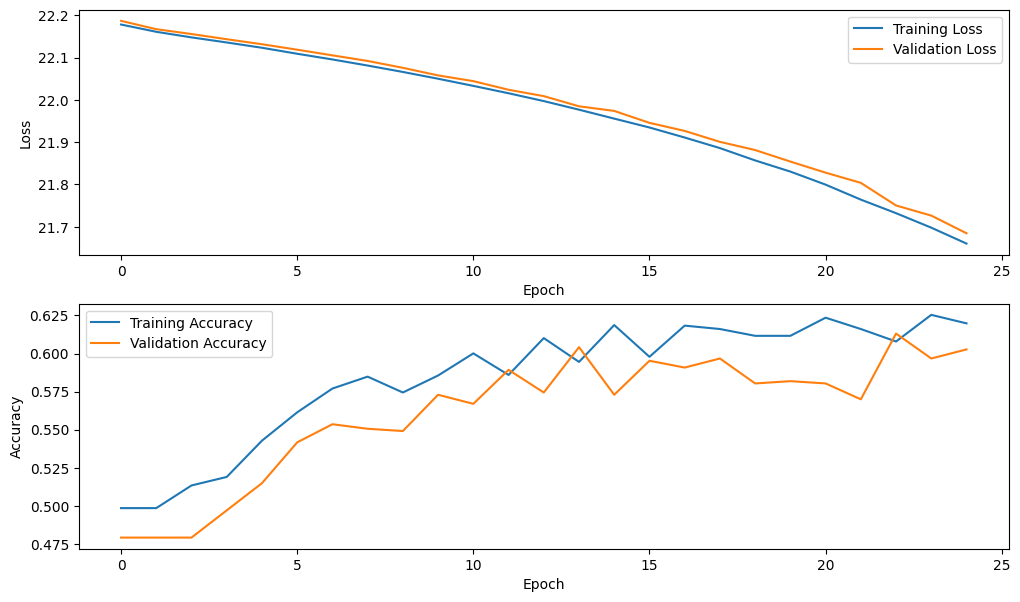

In [ ]:
# Train the model
train_losses = []
train_accs = []
val_losses = []
val_accs = []

starttime = time.time()

for epoch in range(num_epochs):
    # Train the model for one epoch
    model.train()
    running_loss = 0.0
    running_corrects = 0
    train_predictions = []
    train_labels = []
    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        # running_corrects += torch.sum(preds == labels.data)
        train_predictions += preds.tolist()
        train_labels += labels.tolist()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = accuracy_score(train_labels, train_predictions)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Test the model for one epoch
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            # running_corrects += torch.sum(preds == labels.data)
            val_predictions += preds.tolist()
            val_labels += labels.tolist()
    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = accuracy_score(val_labels, val_predictions)
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

# Print the training time
runtime = time.time() - starttime
print(f'Time taken to train: {runtime:.2f} seconds')

# Plot the training and testing losses and accuracies
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Test the model on test data

# Put the model in evaluation mode
model.eval()

# Create a dataloader for the test set
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define some variables to keep track of the test statistics
test_running_loss = 0.0
test_running_corrects = 0
test_predictions = []
test_labels = []

# Iterate over the test set
for inputs, labels in test_dataloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Compute loss and accuracy
    loss = criterion(outputs, labels)
    test_running_loss += loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(preds == labels.data)

    # Collect predictions and labels for computing metrics later
    test_predictions += preds.tolist()
    test_labels += labels.tolist()

# Compute test loss and accuracy
test_loss = test_running_loss / len(test_dataset)
test_accuracy = accuracy_score(test_labels,test_predictions)

# Compute F1 score and classification report
test_f1_score = f1_score(test_labels,test_predictions)
test_classification_report = classification_report(test_labels, test_predictions)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}')
print(f'Test Classification Report:\n{test_classification_report}')

Test Loss: 21.7307, Test Accuracy: 0.6118, Test F1 Score: 0.6359
Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.57      0.58       399
           1       0.62      0.65      0.64       433

    accuracy                           0.61       832
   macro avg       0.61      0.61      0.61       832
weighted avg       0.61      0.61      0.61       832



___
## Change learning rate

In [ ]:
# Define the CNN model
class LeafClassifier(nn.Module):
    def __init__(self):
        super(LeafClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        # x = x.view(-1, 128 * 56 * 56)
        x = x.reshape(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model and move it to the device
model = LeafClassifier().to(DEVICE)

# Define the loss function, optimizer and number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
num_epochs = 25

Epoch 1/25: Train Loss: 22.1645, Train Acc: 0.5067, Val Loss: 22.1096, Val Acc: 0.5357
Epoch 2/25: Train Loss: 22.0632, Train Acc: 0.5599, Val Loss: 22.0486, Val Acc: 0.5238
Epoch 3/25: Train Loss: 21.9237, Train Acc: 0.5688, Val Loss: 21.8245, Val Acc: 0.5476
Epoch 4/25: Train Loss: 21.6901, Train Acc: 0.5915, Val Loss: 21.8556, Val Acc: 0.5446
Epoch 5/25: Train Loss: 21.4525, Train Acc: 0.5911, Val Loss: 21.3509, Val Acc: 0.5744
Epoch 6/25: Train Loss: 21.2151, Train Acc: 0.6068, Val Loss: 21.1032, Val Acc: 0.5982
Epoch 7/25: Train Loss: 21.0854, Train Acc: 0.5967, Val Loss: 21.0190, Val Acc: 0.6012
Epoch 8/25: Train Loss: 20.8324, Train Acc: 0.6176, Val Loss: 20.7451, Val Acc: 0.5952
Epoch 9/25: Train Loss: 20.6514, Train Acc: 0.6112, Val Loss: 20.6347, Val Acc: 0.6027
Epoch 10/25: Train Loss: 20.4787, Train Acc: 0.6261, Val Loss: 20.9130, Val Acc: 0.6086
Epoch 11/25: Train Loss: 20.3192, Train Acc: 0.6269, Val Loss: 20.3893, Val Acc: 0.6161
Epoch 12/25: Train Loss: 20.1597, Train A

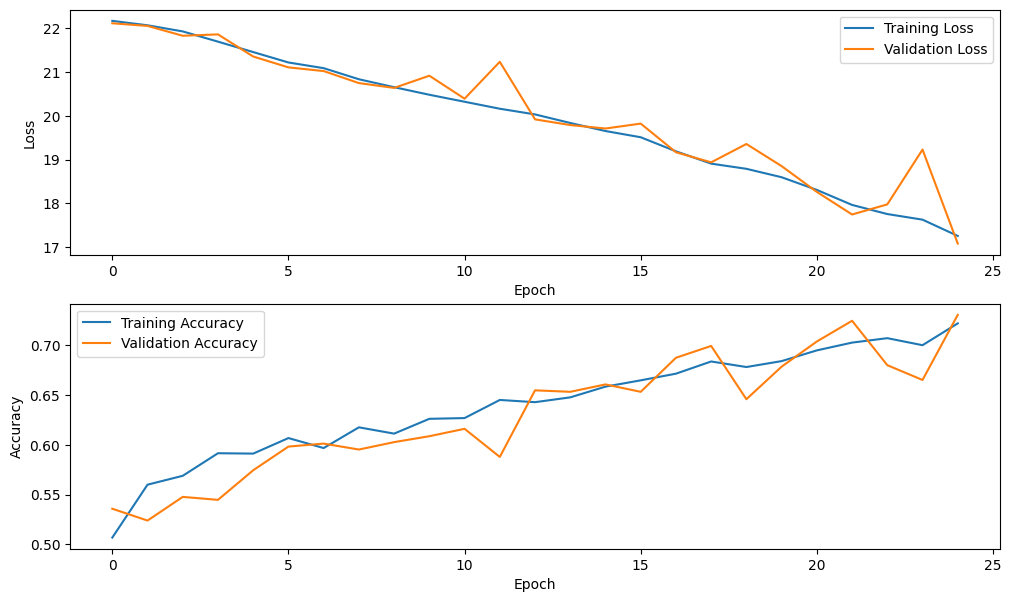

In [ ]:
# Train the model
train_losses = []
train_accs = []
val_losses = []
val_accs = []

starttime = time.time()

for epoch in range(num_epochs):
    # Train the model for one epoch
    model.train()
    running_loss = 0.0
    running_corrects = 0
    train_predictions = []
    train_labels = []
    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        # running_corrects += torch.sum(preds == labels.data)
        train_predictions += preds.tolist()
        train_labels += labels.tolist()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = accuracy_score(train_labels, train_predictions)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Test the model for one epoch
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            # running_corrects += torch.sum(preds == labels.data)
            val_predictions += preds.tolist()
            val_labels += labels.tolist()
    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = accuracy_score(val_labels, val_predictions)
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

# Print the training time
runtime = time.time() - starttime
print(f'Time taken to train: {runtime:.2f} seconds')

# Plot the training and testing losses and accuracies
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Test the model on test data

# Put the model in evaluation mode
model.eval()

# Create a dataloader for the test set
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define some variables to keep track of the test statistics
test_running_loss = 0.0
test_running_corrects = 0
test_predictions = []
test_labels = []

# Iterate over the test set
for inputs, labels in test_dataloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Compute loss and accuracy
    loss = criterion(outputs, labels)
    test_running_loss += loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(preds == labels.data)

    # Collect predictions and labels for computing metrics later
    test_predictions += preds.tolist()
    test_labels += labels.tolist()

# Compute test loss and accuracy
test_loss = test_running_loss / len(test_dataset)
test_accuracy = accuracy_score(test_labels,test_predictions)

# Compute F1 score and classification report
test_f1_score = f1_score(test_labels,test_predictions)
test_classification_report = classification_report(test_labels, test_predictions)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}')
print(f'Test Classification Report:\n{test_classification_report}')

Test Loss: 17.7423, Test Accuracy: 0.7200, Test F1 Score: 0.6732
Test Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.90      0.75       399
           1       0.86      0.55      0.67       433

    accuracy                           0.72       832
   macro avg       0.75      0.73      0.71       832
weighted avg       0.76      0.72      0.71       832



___
## Increase to 100 epochs

In [ ]:
# Define the CNN model
class LeafClassifier(nn.Module):
    def __init__(self):
        super(LeafClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        # x = x.view(-1, 128 * 56 * 56)
        x = x.reshape(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model and move it to the device
model = LeafClassifier().to(DEVICE)

# Define the loss function, optimizer and number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
num_epochs = 100

Epoch 1/100: Train Loss: 22.1589, Train Acc: 0.5197, Val Loss: 22.1307, Val Acc: 0.4807
Epoch 2/100: Train Loss: 22.0278, Train Acc: 0.5316, Val Loss: 22.0044, Val Acc: 0.5253
Epoch 3/100: Train Loss: 21.9568, Train Acc: 0.5595, Val Loss: 21.8266, Val Acc: 0.6161
Epoch 4/100: Train Loss: 21.7204, Train Acc: 0.5785, Val Loss: 21.5758, Val Acc: 0.6116
Epoch 5/100: Train Loss: 21.4768, Train Acc: 0.5938, Val Loss: 21.5441, Val Acc: 0.5521
Epoch 6/100: Train Loss: 21.2137, Train Acc: 0.6034, Val Loss: 21.7047, Val Acc: 0.5521
Epoch 7/100: Train Loss: 20.9913, Train Acc: 0.6109, Val Loss: 21.1545, Val Acc: 0.5833
Epoch 8/100: Train Loss: 20.7771, Train Acc: 0.6183, Val Loss: 20.6292, Val Acc: 0.6116
Epoch 9/100: Train Loss: 20.6250, Train Acc: 0.6231, Val Loss: 20.5322, Val Acc: 0.6012
Epoch 10/100: Train Loss: 20.3974, Train Acc: 0.6376, Val Loss: 20.3453, Val Acc: 0.6235
Epoch 11/100: Train Loss: 20.3009, Train Acc: 0.6310, Val Loss: 20.7705, Val Acc: 0.6146
Epoch 12/100: Train Loss: 20.1

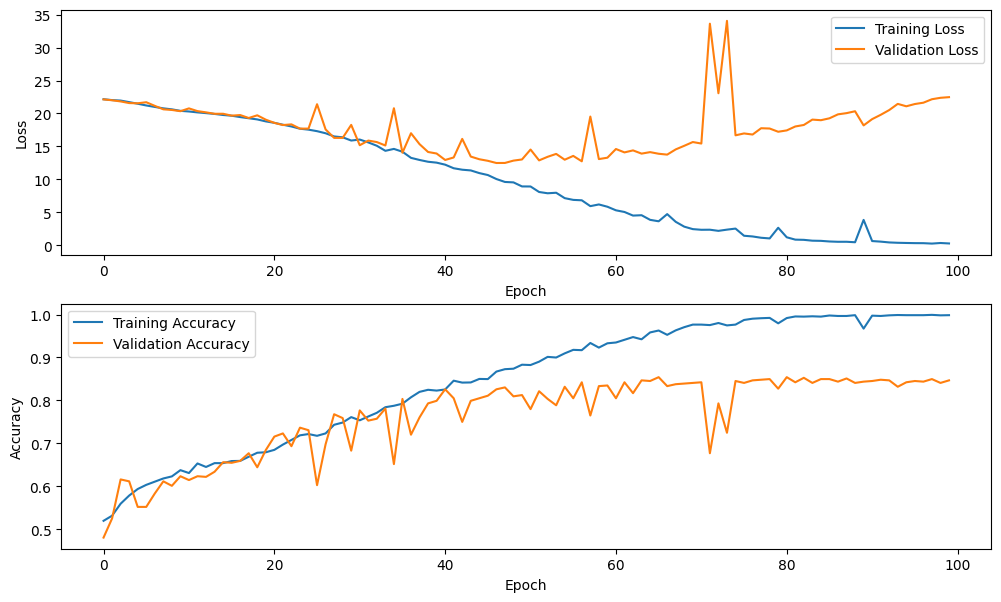

In [ ]:
# Train the model
train_losses = []
train_accs = []
val_losses = []
val_accs = []

starttime = time.time()

for epoch in range(num_epochs):
    # Train the model for one epoch
    model.train()
    running_loss = 0.0
    running_corrects = 0
    train_predictions = []
    train_labels = []
    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        # running_corrects += torch.sum(preds == labels.data)
        train_predictions += preds.tolist()
        train_labels += labels.tolist()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = accuracy_score(train_labels, train_predictions)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Test the model for one epoch
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            # running_corrects += torch.sum(preds == labels.data)
            val_predictions += preds.tolist()
            val_labels += labels.tolist()
    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = accuracy_score(val_labels, val_predictions)
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

# Print the training time
runtime = time.time() - starttime
print(f'Time taken to train: {runtime:.2f} seconds')

# Plot the training and testing losses and accuracies
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Test the model on test data

# Put the model in evaluation mode
model.eval()

# Create a dataloader for the test set
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define some variables to keep track of the test statistics
test_running_loss = 0.0
test_running_corrects = 0
test_predictions = []
test_labels = []

# Iterate over the test set
for inputs, labels in test_dataloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Compute loss and accuracy
    loss = criterion(outputs, labels)
    test_running_loss += loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(preds == labels.data)

    # Collect predictions and labels for computing metrics later
    test_predictions += preds.tolist()
    test_labels += labels.tolist()

# Compute test loss and accuracy
test_loss = test_running_loss / len(test_dataset)
test_accuracy = accuracy_score(test_labels,test_predictions)

# Compute F1 score and classification report
test_f1_score = f1_score(test_labels,test_predictions)
test_classification_report = classification_report(test_labels, test_predictions)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}')
print(f'Test Classification Report:\n{test_classification_report}')

Test Loss: 24.9096, Test Accuracy: 0.8474, Test F1 Score: 0.8490
Test Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       399
           1       0.88      0.82      0.85       433

    accuracy                           0.85       832
   macro avg       0.85      0.85      0.85       832
weighted avg       0.85      0.85      0.85       832



___
___
___